In [18]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder ,StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score,silhouette_score
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

In [2]:
customers = pd.read_csv('Customers.csv')
customers.head(2)

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13


In [3]:
products = pd.read_csv('Products.csv')
products.head(2)

,ProductID,ProductName,Category,Price
0,P001,ActiveWear Biography,Books,169.3
1,P002,ActiveWear Smartwatch,Electronics,346.3


In [4]:
transactions = pd.read_csv('Transactions.csv')
transactions.head(2)

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68


In [5]:
customers_copy = customers.copy()
products_copy = products.copy()
transactions_copy = transactions.copy()

# Clustering logic

In [11]:
customer_summary = transactions_copy.groupby("CustomerID").agg(Total_Spending=("TotalValue", "sum"),Purchase_Count=("TransactionID", "count"),
    Unique_Products=("ProductID", "nunique"),
).reset_index()
customer_features = customers_copy.merge(customer_summary, on="CustomerID", how="left").fillna(0)
customer_features = pd.get_dummies(customer_features, columns=["Region"], drop_first=True)
scaler = MinMaxScaler()
num_cols = ["Total_Spending", "Purchase_Count", "Unique_Products"]
customer_features[num_cols] = scaler.fit_transform(customer_features[num_cols])


In [7]:
customer_features.head()

,CustomerID,CustomerName,SignupDate,Total_Spending,Purchase_Count,Unique_Products,Region_Europe,Region_North America,Region_South America
0,C0001,Lawrence Carroll,2022-07-10,-0.051884,0.000000,0.060991,False,False,True
1,C0002,Elizabeth Lutz,2022-02-13,-0.862714,-0.451294,-0.408172,False,False,False
2,C0003,Michael Rivera,2024-03-07,-0.393842,-0.451294,-0.408172,False,False,True
3,C0004,Kathleen Rodriguez,2022-10-09,1.035375,1.353881,1.468481,False,False,True
4,C0005,Laura Weber,2022-08-15,-0.769499,-0.902587,-0.877335,False,False,False


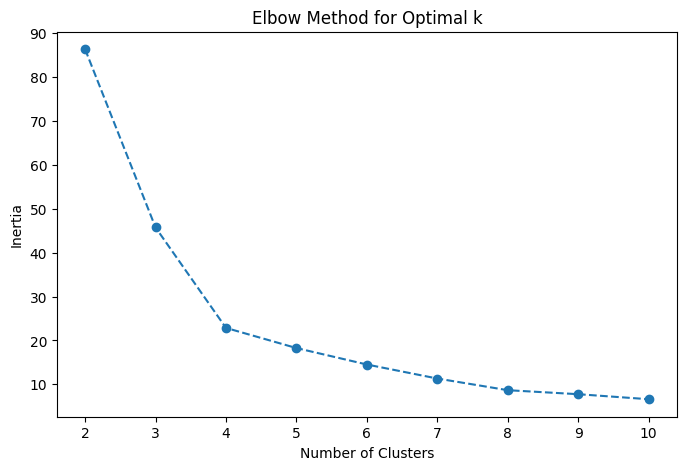

In [12]:
features_for_clustering = customer_features.drop(columns=["CustomerID", "CustomerName", "SignupDate"])
inertia = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_for_clustering)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker="o", linestyle="--")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

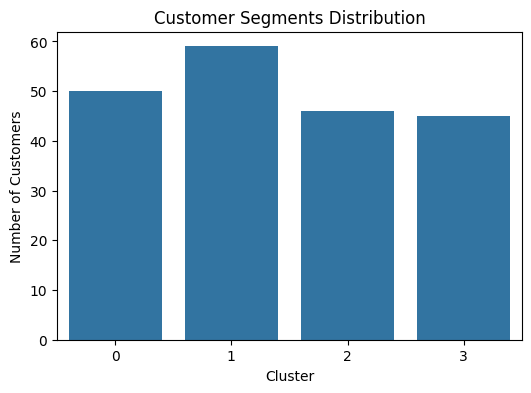

,CustomerID,CustomerName,SignupDate,Total_Spending,Purchase_Count,Unique_Products,Region_Europe,Region_North America,Region_South America,Cluster
0,C0001,Lawrence Carroll,2022-07-10,0.314274,0.454545,0.5,False,False,True,1
1,C0002,Elizabeth Lutz,2022-02-13,0.174514,0.363636,0.4,False,False,False,3
2,C0003,Michael Rivera,2024-03-07,0.255332,0.363636,0.4,False,False,True,1
3,C0004,Kathleen Rodriguez,2022-10-09,0.501681,0.727273,0.8,False,False,True,1
4,C0005,Laura Weber,2022-08-15,0.190581,0.272727,0.3,False,False,False,3


In [13]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_features["Cluster"] = kmeans.fit_predict(features_for_clustering)

plt.figure(figsize=(6,4))
sns.countplot(x=customer_features["Cluster"])
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.title("Customer Segments Distribution")
plt.show()

customer_features.head()


# clustering evaluation metrics

In [14]:
db_index = davies_bouldin_score(features_for_clustering, customer_features["Cluster"])
print(f"Davies-Bouldin Index: {db_index}")

silhouette_avg = silhouette_score(features_for_clustering, customer_features["Cluster"])
print(f"Silhouette Score: {silhouette_avg}")

Davies-Bouldin Index: 0.6099258199285793
Silhouette Score: 0.6396779917743122


# Visual representation of clusters

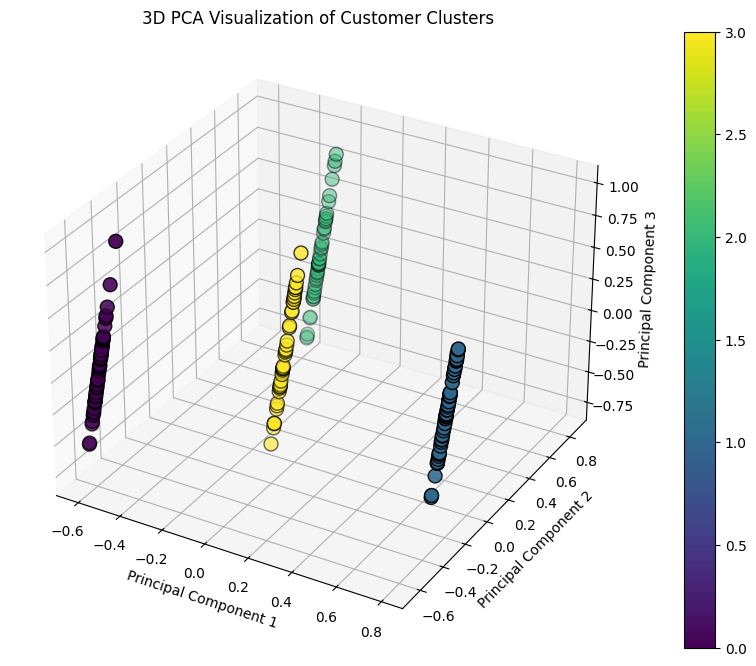

In [20]:
pca_3d = PCA(n_components=3)
pca_features_3d = pca_3d.fit_transform(features_for_clustering)
pca_df_3d = pd.DataFrame(pca_features_3d, columns=["PCA1", "PCA2", "PCA3"])
pca_df_3d["Cluster"] = customer_features["Cluster"]

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(
    pca_df_3d["PCA1"], pca_df_3d["PCA2"], pca_df_3d["PCA3"], 
    c=pca_df_3d["Cluster"], cmap="viridis", s=100, edgecolor="black"
)

ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.set_title("3D PCA Visualization of Customer Clusters")
plt.colorbar(sc)
plt.show()


In [22]:
numeric_cols = customer_features.select_dtypes(include=['number']).columns
cluster_summary = customer_features[numeric_cols].groupby(customer_features["Cluster"]).mean()

In [23]:
cluster_summary

,Total_Spending,Purchase_Count,Unique_Products,Cluster
Cluster,,,,
0,0.311517,0.425455,0.462000,0.0
1,0.348312,0.468413,0.496610,1.0
2,0.310212,0.482213,0.526087,2.0
3,0.316609,0.440404,0.462222,3.0


## **Key Insights**
- **Cluster 1 & Cluster 2**: Represent the **most engaged customers**, characterized by **high spending** and **frequent purchases**. These customers are likely to respond well to **loyalty programs** and **personalized offers**.
- **Cluster 3**: Contains customers with a **diverse shopping pattern** but **slightly lower spending**. This group might be influenced by **targeted cross-category promotions**.
- **Cluster 0**: Consists of **moderate shoppers** who are **consistent but not highly engaged**. Strategies like **re-engagement campaigns** and **discounted subscriptions** may help increase their activity.

These insights enable a **data-driven approach** to customer segmentation, helping to optimize marketing strategies and business decisions.
